# Marginal Logistic Models 

Last time, we focused on linear models, including OLS, marginal, and multilevel, with the NHANES national health and nutrition data set (https://crawstat.com/2020/06/17/marginal-multilevel-linear-models/). This time, working with the same data set, we'll focus on logistic models, which are used to predict the odds (probability) of an event, in this case the binary categorical variable of whether or not a person has smoked at least 100 cigarettes in their life. We'll first fit a simple binomial logistic regression assuming independent samples and diagnose its probability structure and non-linearity. We'll then fit a marginal logistic model to take into account within-cluster dependencies in NHANES' county-level geographic cluster design.  

**Part 1**: fit and diagnose a logistic regression of smoker status on 5 predictors assuming fully independent samples.

**Part 2**: visualize and assess probability structure by plotting log odds and odds against select focus variables.

**Part 3**: visualize and assess non-linearity by generating partial residual, added variable, and CERES plots.

**Part 4**: fit and compare a marginal logistic model.

We'll fit logistic models as well as diagnose and compare them by interpreting parameters, standard errors, variance, and residual plots. We'll compare both log odds and odds (probability) of someone being a smoker based on their combination of variables. We'll also see within-cluster dependencies in action and how accounting for them helps us develop more accurate and meaningful models. Let's dig in.

## Part 1: Logistic Regression on 5 Covariates Assuming Fully Independent Samples

In [429]:
# Import relevant libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from scipy.stats import t
import numpy as np
import scipy.stats.distributions as dist
from IPython.display import display, HTML

In [430]:
# Read the data set and have a look at the first few rows to a get a feel for it
pd.set_option("display.max_columns", 100)
da = pd.read_csv("https://raw.githubusercontent.com/kshedden/statswpy/master/NHANES/merged/nhanes_2015_2016.csv")
da.head(5)

,SEQN,ALQ101,ALQ110,ALQ130,SMQ020,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,DMDMARTL,DMDHHSIZ,WTINT2YR,SDMVPSU,SDMVSTRA,INDFMPIR,BPXSY1,BPXDI1,BPXSY2,BPXDI2,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,HIQ210
0,83732,1.0,NaN,1.0,1,1,62,3,1.0,5.0,1.0,2,134671.37,1,125,4.39,128.0,70.0,124.0,64.0,94.8,184.5,27.8,43.3,43.6,35.9,101.1,2.0
1,83733,1.0,NaN,6.0,1,1,53,3,2.0,3.0,3.0,1,24328.56,1,125,1.32,146.0,88.0,140.0,88.0,90.4,171.4,30.8,38.0,40.0,33.2,107.9,NaN
2,83734,1.0,NaN,NaN,1,1,78,3,1.0,3.0,1.0,2,12400.01,1,131,1.51,138.0,46.0,132.0,44.0,83.4,170.1,28.8,35.6,37.0,31.0,116.5,2.0
3,83735,2.0,1.0,1.0,2,2,56,3,1.0,5.0,6.0,1,102718.00,1,131,5.00,132.0,72.0,134.0,68.0,109.8,160.9,42.4,38.5,37.7,38.3,110.1,2.0
4,83736,2.0,1.0,1.0,2,2,42,4,1.0,4.0,3.0,5,17627.67,2,126,1.23,100.0,70.0,114.0,54.0,55.2,164.9,20.3,37.4,36.0,27.2,80.4,2.0


In [431]:
# We're going to be using seaborn for plots, set style to darkgrid
sns.set_style("darkgrid")
sns.set(style='ticks', palette='Set2')

In [432]:
# Check the column headings
da.columns

Index(['SEQN', 'ALQ101', 'ALQ110', 'ALQ130', 'SMQ020', 'RIAGENDR', 'RIDAGEYR',
       'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDMARTL', 'DMDHHSIZ', 'WTINT2YR',
       'SDMVPSU', 'SDMVSTRA', 'INDFMPIR', 'BPXSY1', 'BPXDI1', 'BPXSY2',
       'BPXDI2', 'BMXWT', 'BMXHT', 'BMXBMI', 'BMXLEG', 'BMXARML', 'BMXARMC',
       'BMXWAIST', 'HIQ210'],
      dtype='object')

In [433]:
# Check the dimensions of the dataframe, this one has 5,735 rows and 28 columns
da.shape

(5735, 28)

In [434]:
# Check number of null values by variable
da.isnull().sum()

SEQN           0
ALQ101       527
ALQ110      4004
ALQ130      2356
SMQ020         0
RIAGENDR       0
RIDAGEYR       0
RIDRETH1       0
DMDCITZN       1
DMDEDUC2     261
DMDMARTL     261
DMDHHSIZ       0
WTINT2YR       0
SDMVPSU        0
SDMVSTRA       0
INDFMPIR     601
BPXSY1       334
BPXDI1       334
BPXSY2       200
BPXDI2       200
BMXWT         69
BMXHT         62
BMXBMI        73
BMXLEG       390
BMXARML      308
BMXARMC      308
BMXWAIST     367
HIQ210      1003
dtype: int64

In [435]:
# Create new gender column using more easily interpretable variables (instead of numeric responses)
da["RIAGENDRx"] = da.RIAGENDR.replace({1: "Male", 2: "Female"})

# Create new ethnicity column using more easily interpretable variables (instead of numeric responses)
da["RIDRETH1x"] = da.RIDRETH1.replace({1: "Mex Amer", 2: "Other Hisp", 3: "Non Hisp White", 4: "Non Hisp Black", 5: "Other"})

# Create new education column using more easily interpretable variables (instead of numeric responses)
da["DMDEDUC2x"] = da.DMDEDUC2.replace({1: "Elementary", 2: "Middle", 3: "HS", 4: "SomeCollege", 5: "College", 7: np.nan, 9: np.nan})

# Create new smoking status column where 1 is yes and 0 is no and don't know and refused are removed
da["SMQ020x"] = da.SMQ020.replace({2: 0, 7: np.nan, 9: np.nan})

In [436]:
keep = ['SDMVSTRA', 'SDMVPSU', 'SMQ020x','RIAGENDRx', 'RIDAGEYR', 'DMDEDUC2x', 
       'INDFMPIR', 'BMXBMI']

In [437]:
# Create new dataframe health with select variables, drop null values with .dropna()
health = da[keep].dropna()
health.head(5)

,SDMVSTRA,SDMVPSU,SMQ020x,RIAGENDRx,RIDAGEYR,DMDEDUC2x,INDFMPIR,BMXBMI
0,125,1,1.0,Male,62,College,4.39,27.8
1,125,1,1.0,Male,53,HS,1.32,30.8
2,131,1,1.0,Male,78,HS,1.51,28.8
3,131,1,0.0,Female,56,College,5.00,42.4
4,126,2,0.0,Female,42,SomeCollege,1.23,20.3


Let's fit our basic logistic model for odds of smoking. If an event has probability `p`, then its odds are `p/(1-p)`, which The odds is a transformation of the probability onto a different scale.  For example, if the probability is 1/2, then the odds is 1. In our case, `p` is the proporition of SMQ020x equal to 1 and `1-p` is the proportion of SMQ020x equal to 0. 

In our output, for our categorical variables, our reference levels are "Female" for gender (RIAGENDRx) and "College" for education (DMDEDUC2x) as they don't show up in the output (they have the lowest log odds of smoking). Keep in mind that for logistic regression, coefficients are applied to log odds and are are additive. On the other hand, comparing odds (probability) is multiplicative. Below, all variable coefficients, except those for elementary level education and BMI have low p-values making them statistically significant. 

Looking at our coefficients, for a given age, BMI, education level, and income to poverty ratio, being a man will increase someone's log odds of smoking by 0.9147 (alternatively, odds increase `exp(0.9147) = 2.5` times). Additionally, someone's log odds of smoking increases by 0.0201 (alternatively, odds increase `exp(0.0201) = 1.02` times) with every year they grow older, holding all other variables constant. On the other hand, someone's log odds of smoking decreases by 0.1033 with every $20,000 rise in annual family income.  

We can also look at specific variable combinations. The log odds for a 50-year-old man being a smoker are `0.9147 + (30 * 0.0201) = 1.5177` units higher that that of a 20-year-old woman, broken out into a 0.9147 increase due to gender and a 0.603 increase due to age. We can exponentiate to derive odds. Since `exp(0.9147 + 0.603) = exp(0.9147) * exp(0.603) = 2.5 * 1.83` we can state that being a man is associated with a 2.5-fold increase in odds of smoking and 30 years of age is associated with a 1.83-fold increase in the odds of smoking. When taken together, a 50-year-old man has `exp(1.52) = 4.56`-fold greater odds of smoking than a 20-year-old woman.



In [438]:
# Fit simple logistic model with 5 covariates: age, gender, BMI, family income to poverty ratio, and education. 
# The family income to poverty ratio (INDFMPIR) uses a poverty level of $20,000 annual income
model = sm.GLM.from_formula("SMQ020x ~ RIDAGEYR + RIAGENDRx + BMXBMI + INDFMPIR + DMDEDUC2x", family=sm.families.Binomial(), data=health)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                SMQ020x   No. Observations:                 4842
Model:                            GLM   Df Residuals:                     4833
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3019.3
Date:                Thu, 18 Jun 2020   Deviance:                       6038.6
Time:                        20:40:48   Pearson chi2:                 4.85e+03
No. Iterations:                     4   Covariance Type:             nonrobust
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.0876      0.185    -11.273      0.000      -2.451      -1.725
RIAGENDRx[T.Male]            0.9147      0.062     14.638      0.000       0.792       1.037
DMDEDUC2x[T.Elementary]      0.0772      0.125      0.619      0.536      -0.167       0.322
DMDEDUC2x[T.HS]              0.8615      0.097      8.860      0.000       0.671       1.052
DMDEDUC2x[T.Middle]          0.9679      0.119      8.144      0.000       0.735       1.201
DMDEDUC2x[T.SomeCollege]     0.7531      0.089      8.418      0.000       0.578       0.928
RIDAGEYR                     0.0201      0.002     11.110      0.000       0.017       0.024
BMXBMI                       0.0007      0.004      0.163      0.870      -0.008       0.009
INDFMPIR                    -0.1033      0.022     -4.670      0.000      -0.147      -0.060
============================================================================================
"""

In [439]:
# Compare male and female odds of smoking. 
# Keep in mind that, in this case, `p` is the proporition of SMQ020x equal to 1 and `1-p` is the proportion of SMQ020x equal to 0.  
gender = pd.crosstab(health.RIAGENDRx, health.SMQ020x).apply(lambda x: x/x.sum(), axis=1)
gender["odds"] = gender.loc[:, 1] / gender.loc[:, 0]
gender

SMQ020x,0.0,1.0,odds
RIAGENDRx,,,
Female,0.679125,0.320875,0.472482
Male,0.470563,0.529437,1.125114


The probability that a woman has ever smoked is 32%, significantly lower than that of a man, 53%. Another way to state this is that the odds of a woman smoking is 0.47, while the odds of a man smoking is 1.13. Calculating the odds ratio below, we see that the odds ratio of smoking for males to females is 2.38, meaning that a man has 2.38 times greater odds of smoking than a woman. 

In [440]:
gender["odds"].Male / gender["odds"].Female

2.381282499589777

In [441]:
# Compare odds of smoking by education level. 
# Keep in mind that, in this case, `p` is the proporition of SMQ020x equal to 1 and `1-p` is the proportion of SMQ020x equal to 0.  
education = pd.crosstab(health.DMDEDUC2x, health.SMQ020x).apply(lambda x: x/x.sum(), axis=1)
education["odds"] = education.loc[:, 1] / education.loc[:, 0]
education

SMQ020x,0.0,1.0,odds
DMDEDUC2x,,,
College,0.725793,0.274207,0.377803
Elementary,0.624772,0.375228,0.600583
HS,0.492904,0.507096,1.028791
Middle,0.443636,0.556364,1.254098
SomeCollege,0.551132,0.448868,0.814446


The probability that someone who completed college has ever smoked is 27%, significantly lower than that of a person who started but didn't finish college, 45%. Another way to state this is that the odds of someone who started but didn't finish college of smoking is 0.81, while the odds of someone who completed college of smoking is 0.38. Calculating the odds ratio below, we see that the odds ratio of smoking for someone who started but didn't finish college is 2.16, meaning that a person who started but didn't finish college has 2.16 times greater odds of smoking than someone who completed college.

In [442]:
education["odds"].SomeCollege / education["odds"].College

2.1557438537236107

## Part 2: Probability Structure

Let's visualize the probability structure of the population from our logistic model, including shaded 95% confidence bounds, by plotting log odds of smoking vs. age for men with a college education. First, we'll need to import predict_functional from statsmodels.sandbox.predict_functional. We also need to fix all of our variables. Our dependent variable is already set as smoking status (SMQ020x). We'll set our independent focus variable as age. We'll set our gender to male, BMI to 25 (the top of the "normal" range for BMI), education level to college, and income to poverty ratio to 5. From our plot, we see increasing log odds of smoking with age, which makes sense as somone is more likely to have smoked at least 100 cigarettes the older they are. 

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/sandbox/predict_functional.py:171: ValueWarning: 'SDMVPSU', 'SDMVSTRA' in data frame but not in summaries or values.
  ValueWarning)


Text(0, 0.5, 'Log Odds Smoking')

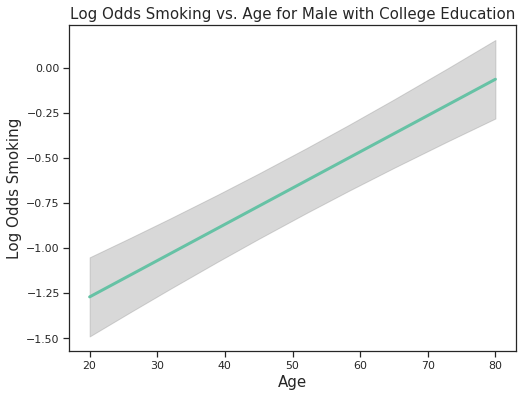

In [443]:
# Import predict_functional
from statsmodels.sandbox.predict_functional import predict_functional

# Fix variables at specific values 
values = {"RIAGENDRx": "Male", "BMXBMI": 25, "DMDEDUC2x": "College", "INDFMPIR" : 5}

# The returned values are the predicted values (pv), confidence bands (cb), and function values (fv).
pv, cb, fv = predict_functional(result, "RIDAGEYR", values=values, ci_method="simultaneous")

plt.figure(figsize=(8, 6))
ax = sns.lineplot(fv, pv, lw=3)
ax.fill_between(fv, cb[:, 0], cb[:, 1], color='grey', alpha=0.3)
ax.set_title("Log Odds Smoking vs. Age for Male with College Education", size=15)
ax.set_xlabel("Age", size=15)
ax.set_ylabel("Log Odds Smoking", size=15)

Let's try the same plot in terms of probabilities instead of log odds. Probability can be obtained from the log odds using the relationship `p = 1 / (1 + exp(-o))` where `o` is the log odds. This time we see a slightly curved relationship. 

Text(0, 0.5, 'Probability Smoking')

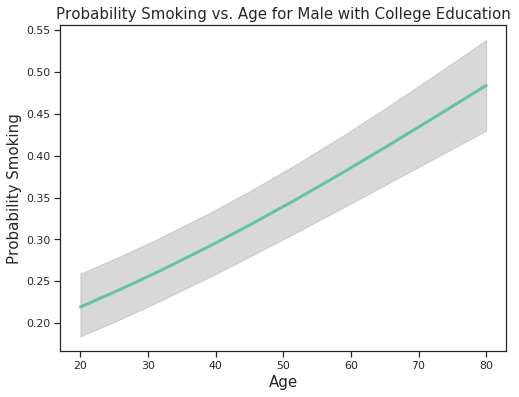

In [444]:
plt.figure(figsize=(8, 6))
pv_prob = 1 / (1 + np.exp(-pv))
cb_prob = 1 / (1 + np.exp(-cb))
ax = sns.lineplot(fv, pv_prob, lw=3)
ax.fill_between(fv, cb_prob[:, 0], cb_prob[:, 1], color='grey', alpha=0.3)
ax.set_title("Probability Smoking vs. Age for Male with College Education", size=15)
ax.set_xlabel("Age", size=15)
ax.set_ylabel("Probability Smoking", size=15)

This time, let's plot log odds smoking vs. income to poverty ratio for men aged 40. Our dependent variable is already set as somking status (SMQ020x). We'll set our independent focus variable as income to poverty ratio (INDFMPIR). We'll set our gender to male, BMI to 25, education level to college, and age to 40. 

Log odds smoking decreases with a higher income to poverty ratio. Additionally, the shaded gray confidence bounds are a bit wider meaning that the relationship between smoking and income has less certainty than that between smoking and age.

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/sandbox/predict_functional.py:171: ValueWarning: 'SDMVPSU', 'SDMVSTRA' in data frame but not in summaries or values.
  ValueWarning)


Text(0, 0.5, 'Log Odds Smoking')

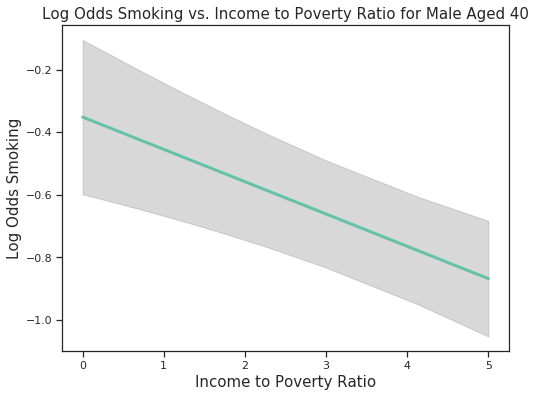

In [445]:
# Fix variables at specific values 
values = {"RIAGENDRx": "Male", "BMXBMI": 25, "DMDEDUC2x": "College", "RIDAGEYR":40}

# The returned values are the predicted values (pv), confidence bands (cb), and function values (fv).
pv, cb, fv = predict_functional(result, "INDFMPIR", values=values, ci_method="simultaneous")

plt.figure(figsize=(8, 6))
ax = sns.lineplot(fv, pv, lw=3)
ax.fill_between(fv, cb[:, 0], cb[:, 1], color='grey', alpha=0.3)
ax.set_title("Log Odds Smoking vs. Income to Poverty Ratio for Male Aged 40", size=15)
ax.set_xlabel("Income to Poverty Ratio", size=15)
ax.set_ylabel("Log Odds Smoking", size=15)

Text(0, 0.5, 'Probability Smoking')

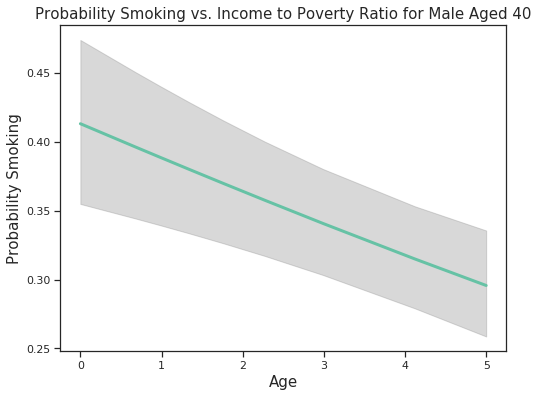

In [446]:
plt.figure(figsize=(8, 6))
pv_prob = 1 / (1 + np.exp(-pv))
cb_prob = 1 / (1 + np.exp(-cb))
ax = sns.lineplot(fv, pv_prob, lw=3)
ax.fill_between(fv, cb_prob[:, 0], cb_prob[:, 1], color='grey', alpha=0.3)
ax.set_title("Probability Smoking vs. Income to Poverty Ratio for Male Aged 40", size=15)
ax.set_xlabel("Age", size=15)
ax.set_ylabel("Probability Smoking", size=15)

## Part 3: Variance Structure

Let's look at our variance structure to see if there's any curvature in the relationship between log odds smoking and a focus variable. Keep in mind that small discrepencies aren't very reliable to draw conclusions from, unless we have a very large sample size. 

#### Partial Residual Plot

A partial residual plot is essentially a synthetic data set removing the effects of all but one variable. We'll see how variance looks like if one independent focus variable is allowed to change while all other independent variables and unexplained variation is fixed. Explained variation can be seen in the red trendline while unexplained variation is seen in the scatter around the trendline.

Let's set our independent focus variable as age (allowed to change) on the x axis, and fix gender, BMI, education, and income to poverty ratio. We see slight curvature with smoking increasing more quickly from age 20 to 35, flattening out, and rising faster again from age 50 to 60. 

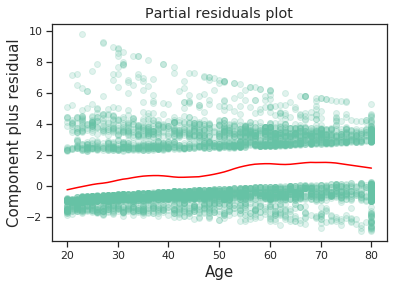

In [447]:
# Import add_lowess
from statsmodels.graphics.regressionplots import add_lowess

fig = result.plot_partial_residuals("RIDAGEYR")
ax = fig.get_axes()[0]
ax.lines[0].set_alpha(0.2)
ax.set_xlabel("Age", size=15)
_ = add_lowess(ax)

#### Added Variable Plot

We can also look for non-linearity with an added variable plot. Note that log odds smoking residuals and age have been centered around their respective means. Similar to the partial residuals plot, we see curvature with smoking rising more quickly from age 20 to 35, dipping a bit, and then increasing more quickly again after that.

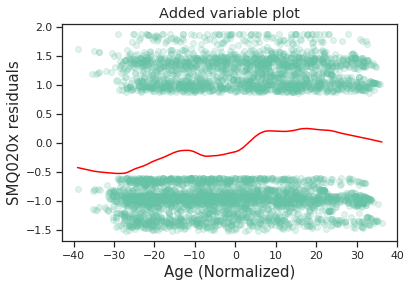

In [448]:
fig = result.plot_added_variable("RIDAGEYR")
ax = fig.get_axes()[0]
ax.lines[0].set_alpha(0.2)
ax.set_xlabel("Age (Normalized)", size=15)
_ = add_lowess(ax)

#### CERES Plot

A CERES (conditional expectation partial residuals) plot are most supportive in assessing non-linearity. Here again, we see the slight curvature around in early and late age ranges. 

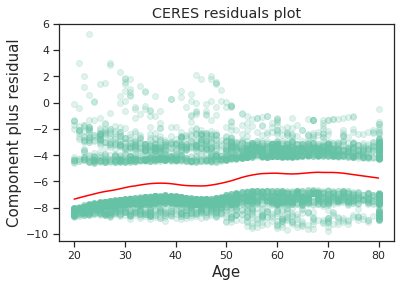

In [449]:
fig = result.plot_ceres_residuals("RIDAGEYR")
ax = fig.get_axes()[0]
ax.lines[0].set_alpha(0.2)
ax.set_xlabel("Age", size=15)
_ = add_lowess(ax)

## Part 4: Marginal Logistic Model

NHANES follows a complex sampling design, specifically geographic cluster sampling. You can learn more here (https://www.cdc.gov/nchs/tutorials/nhanes/SurveyDesign/SampleDesign/Info1.htm). In the sampling design, primary sampling units (SDMVPSU) include counties, which are then divided into subregions, from which households are drawn and individuals are sampled. In order to pretect individuals' confidentiality, masked variance units (SDMVSTRA) combine subregions of different counties to mimic contiguous subregions. While they're not the actual original clusters, they can be treated as proxies of the original clusters with variances that closely approximate those of the original true design. We can arrive at their identifiers by combining them. 

In [450]:
# Form cluster variable 
health["cluster"] = 10*health.SDMVSTRA + health.SDMVPSU

Let's check if there is within-cluster correlation in our sample design. We set our correlation structure as exchangeable, which assumes constant correlation of observations within a cluster.

We see that we clearly have within-cluster correlation in the intercepts of our variables ranging from 0.025 to 0.067. While these seem low, they're not directly comparable to a Pearson correlation and are actually fairly high (0 means perfect independence while 1 means perfect clustering where values are identical).

In [451]:
# Within-cluster correlation of multiple variables using GEE without covariates, only an intercept (""~1"), and exchangeable correlation structure. 
for v in ["SMQ020x", "RIDAGEYR", "BMXBMI", "INDFMPIR"]:
    model = sm.GEE.from_formula(v + " ~ 1", groups="cluster", cov_struct=sm.cov_struct.Exchangeable(), data=health)
    result = model.fit()
    print(v, result.cov_struct.summary())

SMQ020x The correlation between two observations in the same cluster is 0.024
RIDAGEYR The correlation between two observations in the same cluster is 0.037
BMXBMI The correlation between two observations in the same cluster is 0.042
INDFMPIR The correlation between two observations in the same cluster is 0.069


Now that we know that we have within-cluster correlation, let's fit a marginal model using a generalized estimating equation (GEE). Let's also construct a table to compare parameters and standard error between GEE and our basic logistic model (GLM) for all of our variables. Since GLM assumes independent samples and doesn't take into account within-cluster correlation, it will often underrepresent standard error. As expected, GEE standard errors are often higher than those of GLM.

Since we know that there are within-cluster dependencies, GLM is not justified and GEE is a superior fit with more accurate and meaningful parameters and standard errors (assuming exclusively within-cluster and not between-cluster dependencies).

In [452]:
# Fit simple logistic model using GLM
GLM = sm.GLM.from_formula("SMQ020x ~ RIDAGEYR + RIAGENDRx + BMXBMI + INDFMPIR + DMDEDUC2x", family=sm.families.Binomial(), data=health)
result_GLM = GLM.fit()
result_GLM.summary()

# Fit a marginal logistic model using GEE and exchangeable correlation structure
GEE = sm.GEE.from_formula("SMQ020x ~ RIDAGEYR + RIAGENDRx + BMXBMI + INDFMPIR + DMDEDUC2x", groups="cluster", family=sm.families.Binomial(), cov_struct=sm.cov_struct.Exchangeable(), data=health)
result_GEE = GEE.fit(start_params = result_GLM.params)

# Create dataframe for comparing OLS and GEE parameters and standard errors
compare = pd.DataFrame({"GLM Params": result_GLM.params, "GLM SE": result_GLM.bse, "GEE Params": result_GEE.params, "GEE SE": result_GEE.bse})
compare = compare[["GLM Params", "GLM SE", "GEE Params", "GEE SE"]]

# Print out the results in a pretty way
display(HTML(compare.to_html()))

,GLM Params,GLM SE,GEE Params,GEE SE
Intercept,-2.087608,0.185180,-2.032925,0.252482
RIAGENDRx[T.Male],0.914722,0.062488,0.911255,0.073352
DMDEDUC2x[T.Elementary],0.077181,0.124670,0.135482,0.146968
DMDEDUC2x[T.HS],0.861546,0.097235,0.818631,0.102278
DMDEDUC2x[T.Middle],0.967894,0.118851,0.944766,0.157328
DMDEDUC2x[T.SomeCollege],0.753060,0.089458,0.706626,0.108082
RIDAGEYR,0.020099,0.001809,0.019514,0.001765
BMXBMI,0.000715,0.004373,-0.000041,0.005314
INDFMPIR,-0.103343,0.022128,-0.100207,0.021294
